In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output

import copy

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd

from torch.utils.data import DataLoader

from train_utils import *
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from mlp_model import MLP_NonlinearEncoder
from models_utils import init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

# Load data 

In [50]:
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':False,
                    'scaler':None #SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [51]:
inpt.mean(1), inpt.std(1)

(array([-6.39488462e-18,  3.05533376e-16,  1.98951966e-17]),
 array([1., 1., 1.]))

In [52]:
inpt.max(1), inpt.min(1), inpt@inpt.T / inpt.shape[1]

(array([1.6041934 , 1.75479329, 2.01865135]),
 array([-1.74066042, -1.7179824 , -1.60481211]),
 array([[ 1.        , -0.00577446,  0.08808828],
        [-0.00577446,  1.        , -0.00863882],
        [ 0.08808828, -0.00863882,  1.        ]]))

In [53]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [54]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [55]:
(inpt_train_torch.T@inpt_train_torch / inpt_train_torch.shape[0]).round()

tensor([[1., -0., 0.],
        [-0., 1., -0.],
        [0., -0., 1.]], device='cuda:0')

In [56]:
inpt_train_torch.mean(0), inpt_train_torch.std(0)

(tensor([ 0.0013, -0.0014,  0.0042], device='cuda:0'),
 tensor([0.9961, 0.9986, 1.0002], device='cuda:0'))

In [57]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

In [58]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt_test, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [1]:
# from mpl_toolkits import mplot3d

# plt.figure(dpi=300)

# ax = plt.axes(projection='3d')

# ax.scatter3D(inpt_test[:,0], inpt_test[:,1], inpt_test[:,2], c=color_test, cmap='viridis')
# plt.show()

# PCA

In [60]:
N_CYCLES = 1
data = [create_data()  for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)
outpt_data = np.concatenate([d[1] for d in data],-1)

3


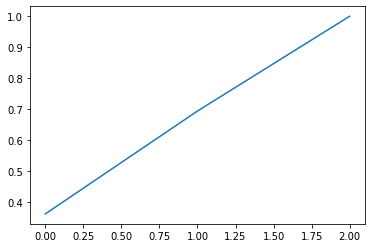

In [61]:
pca = PCA()
Z_pca = pca.fit_transform(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [62]:
# plt.scatter(Z_pca[:,0], Z_pca[:,1], c=outpt_data[0])
# plt.colorbar()

In [63]:
# Z_pca_test = pca.transform(inpt_test.T)
# plt.scatter(Z_pca_test[:,0], Z_pca_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [64]:
# umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
# Z = umap.fit_transform(inpt_data.T)
# Z_test = umap.transform(inpt_test.T)

In [65]:
# plt.scatter(Z[:,0], Z[:,1], c=outpt_data[0])
# plt.colorbar()

In [18]:
# plt.scatter(Z_test[:,0], Z_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [19]:
# Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [20]:
# Q_loc_val_UMAP, Q_glob_val_UMAP

# Train MLP

### Hebbian parameters

In [21]:
# encoder_parameters = {
#                     'input_dim':inpt.shape[0],
#                     'hidden_dim':10,
#                     'embedding_dim':2,
#                     'add_readout':False,
#                     'add_recurrent_connections':True,
#                     'add_recurrent_nonlinearity':True,
#                     'hebbian_update':oja_rule,
#                     'inplace_update':False,
#                     'normalize_hebbian_update':False,
#                     'lr_hebb':1e-4,
#                     'W_requires_grad':False,
#                     'W_r_requires_grad':False,
#                     'f_requires_grad':False,
#                     'final_nonlinearity':False,
#                     'parametrized_f':False,
#                     'nonlinearity': nn.Tanh(),
#                     'f_kwargs':None,
#                     'layers_number':2,
#                     'add_bn':False,
#                     'seed':None,
#                     'set_seed':False,
#                      }

# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

### Backprop parameters

In [116]:
encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':5,
                    'embedding_dim':2,
                    'add_readout':False,
                    'add_recurrent_connections':False,
                    'add_recurrent_nonlinearity':False,
                    'hebbian_update':None,
                    'inplace_update':False,
                    'normalize_hebbian_update':False,
                    'lr_hebb':None,
                    'W_requires_grad':True,
                    'W_r_requires_grad':True,
                    'f_requires_grad':True,
                    'final_nonlinearity':False,
                    'parametrized_f':False,
                    'nonlinearity': nn.Tanh(),
                    'f_kwargs':None,
                    'layers_number':3,
                    'add_bn':True,
                    'seed':None,
                    'set_seed':False,
                     }

network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

Net capacity: 50
Parameters:
W_s.0 torch.Size([5, 3]) requires_grad: True
W_s.1 torch.Size([5, 5]) requires_grad: True
W_s.2 torch.Size([2, 5]) requires_grad: True


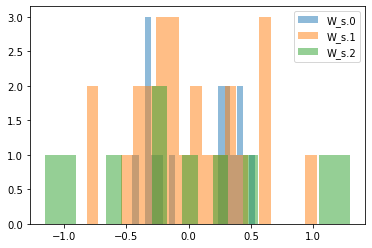

In [117]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad)
#     plt.figure()
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=20, alpha=0.5, label=f'{name}')
#     W /= np.linalg.norm(W, axis=1, keepdims=True)
#     print(W@W.T)
plt.legend()
plt.show()

In [118]:
X_s = network.forward(inpt_test_torch)
outpt_val_pred = to_numpy(X_s[-1])
outpt_val_pred.shape

(2, 1000)

In [119]:
for W in network.W_s:
    print(W.shape)

torch.Size([5, 3])
torch.Size([5, 5])
torch.Size([2, 5])


In [120]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

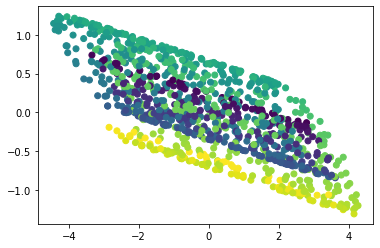

In [121]:
plt.scatter(outpt_val_pred[0], outpt_val_pred[1], c=color_test)
plt.show()

In [122]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
train_graph_data = graph_constructor(inpt_train)
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 5000

dataset_train = UMAPDataset(inpt_train, *train_graph_data, device=device, batch_size=BATCH_SIZE_BP)
dataset_test = UMAPDataset(inpt_test, *test_graph_data, device=device, batch_size=BATCH_SIZE_BP)

# for hebbian update
train_hebb_dataloader = DataLoader(inpt_train_torch, batch_size=2, shuffle=True)

criterion_umap = UMAPLoss(device=device, 
                         min_dist=0.15,
                         negative_sample_rate=2,
                         edge_weight=None,
                         repulsion_strength=1.0)

criterion = umap_criterion_compatibility(criterion_umap)

Wed Jul 20 13:07:58 2022 Building RP forest with 10 trees
Wed Jul 20 13:07:58 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Wed Jul 20 13:07:58 2022 Building RP forest with 7 trees
Wed Jul 20 13:07:58 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


In [123]:
len(dataset_train), len(dataset_test)

(213, 24)

In [124]:
for batch in dataset_test:
    break
batch.shape

torch.Size([5000, 3])

In [125]:
X_s = network.forward(batch)
criterion(X_s)

tensor(0.4007, device='cuda:0', grad_fn=<MeanBackward0>)

In [126]:
type(X_s[0][0][0])

torch.Tensor

In [127]:
for batch in train_hebb_dataloader:
    break
batch.shape

torch.Size([2, 3])

In [128]:
X_s = network.forward(batch)

### Hebbian learning parameters

In [129]:
# training_parameters = edict({'epochs':1000,
#                            'enable_grad_train':False,
#                            'enable_grad_val':False,
#                            'backprop_learning':False,
#                            'hebbian_learning':True,
#                            'lr_bp':1e-3,
#                            'wd_bp':0, 
#                            'maxiter':None, # maxiter
#                            'shuffle':True, # shuffle data
#                            'progress_bar':True,
#                            'weight_saver':None,
#                            'calculate_grad':False,
#                            'clip_grad_value': None,
#                            'val_metrics':None,
#                            'device':device
#                           })

# criterion_kwargs = defaultdict(dict)
# criterion_kwargs['skip_train'] = True
# criterion_kwargs['skip_val'] = False

# opt = None
# if training_parameters['backprop_learning']:
#     opt = optim.Adam(get_grad_params(network.parameters()), 
#                      lr=training_parameters.lr_bp,  
#                      weight_decay=training_parameters.wd_bp)

In [130]:
# metric_dict = None
# training_parameters['epochs'] = 10

# network, opt, metric_dict = train(network, 
#                                   opt=opt, 
#                                   criterion=criterion,
#                                   criterion_kwargs=criterion_kwargs,
#                                   parameters=training_parameters,
#                                   train_dataloader=train_hebb_dataloader,
#                                   val_dataloader=dataset_test, 
#                                   metric_dict=metric_dict,
#                                   val_metrics=None
#                                   )


### Backprop training parameters

In [131]:
training_parameters = edict({'epochs':100,
                           'enable_grad_train':True,
                           'enable_grad_val':True,
                           'backprop_learning':True,
                           'hebbian_learning':False,
                           'lr':1e-4,
                           'wd':0, 
                           'maxiter':1000, # maxiter
                           'shuffle':True, # shuffle data
                           'progress_bar':True,
                           'weight_saver':None,
                           'calculate_grad':False,
                           'clip_grad_value': None,
                           'val_metrics':None,
                           'device':device
                          })

criterion_kwargs = defaultdict(dict)
criterion_kwargs['skip_train'] = False
criterion_kwargs['skip_val'] = False

opt = None
if training_parameters['backprop_learning']:
    opt = optim.Adam(get_grad_params(network.parameters()), 
                     lr=training_parameters.lr,  
                     weight_decay=training_parameters.wd)

In [132]:
if opt is not None:
    print(len(opt.param_groups[0]['params']))

3


In [133]:
metric_dict = None

network, opt, metric_dict = train(network, 
                                  opt=opt, 
                                  criterion=criterion,
                                  criterion_kwargs=criterion_kwargs,
                                  parameters=training_parameters,
                                  train_dataloader=dataset_train,
                                  val_dataloader=dataset_test, 
                                  metric_dict=metric_dict,
                                  val_metrics=None
                                  )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


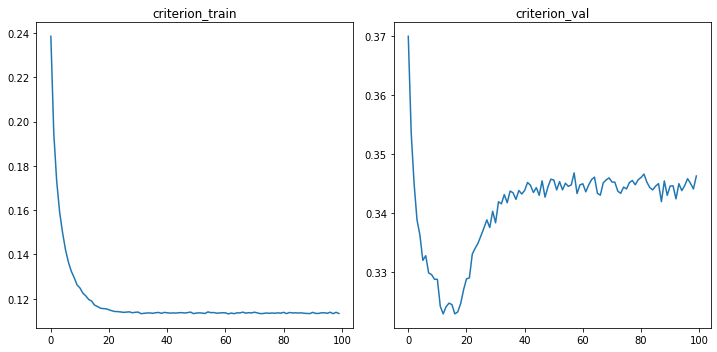

In [134]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,4,1)
ax1.plot(metric_dict['criterion_train'])
ax1.set_title('criterion_train')

ax2 = plt.subplot(1,4,2)
ax2.plot(metric_dict['criterion_val'])
ax2.set_title('criterion_val')

plt.tight_layout()
plt.show()

In [113]:
X_s_pred = network(inpt_test_torch.to(device))
# X_s_pred = network(inpt_train_torch.to(device))

outpt_val_pred = to_numpy(X_s_pred[-1])

In [114]:
# Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test, outpt_val_pred.T)
# Q_loc_val_NET, Q_glob_val_NET

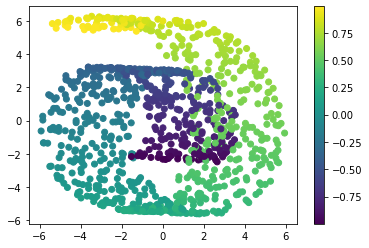

In [115]:
plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test)
plt.colorbar()
plt.show()

In [44]:
X = X_s_pred[1]

In [45]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(X.T, columns=['x','y', 'z'])
# df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)
# fig.show()

#### 3 layers, hidden dim  10
 - $f_{theta}$ only. $Q_l$ 0.52, $Q_g$: 0.75, loss ~ 0.15, still curved and overlapping embedding
 - $f_{theta}$ and $W$. $Q_l$ 0.78, $Q_g$: 0.7, loss ~ 0.07 - nicely flatten 

In [46]:
# root_checkpoints = 'results/mlp_nonlinear/checkpoints'
# hdim = encoder_parameters['hidden_dim']
# lnum = encoder_parameters['layers_number']
# Wgrad = int(encoder_parameters['W_requires_grad'])
# fgrad = int(encoder_parameters['parametrized_f'])
# fname = encoder_parameters['nonlinearity'].__name__
# bn = int(encoder_parameters['add_bn'])

# experiment_name = 'MLP_' + LEARNING_TYPE + f'_hdim-{hdim}' + \
#                   f'_lnum-{lnum}' + f'_Wgrad-{Wgrad}' + f'_fgrad-{fgrad}' + f'_{fname}' + f'_bn-{bn}'

# checkpoint_name = os.path.join(root_checkpoints, experiment_name)
# torch.save(network.state_dict(), checkpoint_name)

In [47]:
# n_fs = len(network.f_s)
# ξ = torch.linspace(-5,5,1000).to(device)

# for layer in range(n_fs):
#     f_theta = network.f_s[layer]
#     if network.final_nonlinearity or layer < n_fs-1:
#         n_neurons = f_theta.input_dim
#         y = torch.stack([ξ for _ in range(n_neurons)],0) # [n_neurons, T]

#         f = to_numpy(f_theta(y)) # [n_neurons, T]

#         fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*3,3))

#         for j,ax in enumerate(axes):
#             ax.plot(to_numpy(ξ), f[j])
#             ax.set_title(f'Neuron: {j}')

#         fig.suptitle(f'Layer: {layer}', y=1.1, color='blue')
    
# plt.tight_layout()
# plt.show()

In [48]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [49]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(np.concatenate([inpt_test, outpt_val_pred], axis=1).T, columns=['x','y', 'z'])

# df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
#                                np.ones((inpt_test.shape[1]))])

# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

# fig.show()